## 멋진 단어사진 만들기 (프로젝트)

SentencePiece 사용하기

### 라이브러리 import

In [5]:
import re
import os
import os.path
import pandas as pd
import numpy as np
import urllib.request

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.initializers import Constant

from collections import Counter
from konlpy.tag import Mecab
import sentencepiece as spm

import gensim
from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split

from keras.layers import LSTM, GRU, Dense, Conv1D
from keras.layers import Embedding, MaxPooling1D, GlobalMaxPooling1D
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

import seaborn as sns
import matplotlib.pyplot as plt
#%matplotlib inline

#import warnings
#warnings.filterwarnings(action='ignore') # (action='default')

### Step 1. SentencePiece 설치하기

https://github.com/google/sentencepiece 에서 상세 내용 확인 가능

In [2]:
!pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.2 MB/s eta 0:00:00a 0:00:01


In [4]:
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.0/24.0 MB 57.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.6/58.6 kB 8.8 MB/s eta 0:00:00


### Step 2. SentencePiece 모델 학습

앞서 배운 tokenize() 함수를 다시 상기

```
def tokenize(corpus):  # corpus: Tokenized Sentence's List
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer
```

tf.keras.preprocessing.text.Tokenizer에 corpus를 주고 tokenizer.fit_on_texts(corpus)을 하면  
토크나이저 내부적으로 단어사전과 토크나이저 기능을 corpus에 맞춤형으로 자동 생성해 주는 것.

In [8]:
import os
path_to_file = '/mnt/disk2/modoo-nlp/sp_tokenizer/data/korean-english-park.train.ko'

In [9]:
with open(path_to_file, "r") as f:
    raw = f.read().splitlines()

cleaned_corpus = list(set(raw))

print('ready')

ready


In [10]:
max_len = 150
min_len = 10

# 길이 조건에 맞는 문장만 선택합니다.
filtered_corpus = [s for s in cleaned_corpus if (len(s) < max_len) & (len(s) >= min_len)]

import sentencepiece as spm
import os
temp_file = '/mnt/disk2/modoo-nlp/sp_tokenizer/data/korean-english-park.train.ko.temp'

vocab_size = 8000

with open(temp_file, 'w') as f:
    for row in filtered_corpus:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
        f.write(str(row) + '\n')
        
print('temp_file write done')

temp_file write done


In [11]:
train_str = '--input={} --model_prefix=korean_spm --vocab_size={}'.format(temp_file, vocab_size) 
print(train_str)

--input=/mnt/disk2/modoo-nlp/sp_tokenizer/data/korean-english-park.train.ko.temp --model_prefix=korean_spm --vocab_size=8000


In [12]:
spm.SentencePieceTrainer.Train(train_str)
#위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.

print('train done')

train done


sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/mnt/disk2/modoo-nlp/sp_tokenizer/data/korean-english-park.train.ko.temp --model_prefix=korean_spm --vocab_size=8000
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /mnt/disk2/modoo-nlp/sp_tokenizer/data/korean-english-park.train.ko.temp
  input_format: 
  model_prefix: korean_spm
  model_type: UNIGRAM
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab

In [13]:
!ls -l korean_spm*

-rw-rw-r-- 1 ubuntu ubuntu 376828 Oct 19 08:26 korean_spm.model
-rw-rw-r-- 1 ubuntu ubuntu 146218 Oct 19 08:26 korean_spm.vocab


위 코드를 실행하면 정상적으로 SentencePiece 모델 학습이 완료된 후 korean_spm.model 파일과 korean_spm.vocab vocabulary 파일이 생성되었음을 확인할 수 있다.

#### SentencePiece 모델을 어떻게 활용?

In [14]:
s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s.SampleEncodeAsPieces('아버지가방에들어가신다.', 2, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))

[1243, 11, 302, 7, 3608, 11, 287, 38, 3]
['▁아버지', '가', '방', '에', '들', '어', '가', '신', '다', '.']
아버지가방에들어가신다.


SentencePiece의 토크나이징 실력이 괜찮은 것 같다.

### Step 3. Tokenizer 함수 작성

우리는 위에서 훈련시킨 SentencePiece를 활용하여 위 함수와 유사한 기능을 하는 sp_tokenize() 함수를 정의할 것이다.

하지만 SentencePiece가 동작하는 방식이 단순 토큰화와는 달라 완전히 동일하게는 정의하기 어렵다.

그러니 아래 조건을 만족하는 함수를 정의하도록 하겠다.
- 매개변수로 토큰화된 문장의 list를 전달하는 대신 온전한 문장의 list 를 전달
- 생성된 vocab 파일을 읽어와 { <word> : <idx> } 형태를 가지는 word_index 사전과 { <idx> : <word>} 형태를 가지는 index_word 사전을 생성하고 함께 반환
- 리턴값인 tensor 는 앞의 함수와 동일하게 토큰화한 후 Encoding된 문장임. 바로 학습에 사용할 수 있게 Padding은 당연히 해야겠죠?

In [15]:
def sp_tokenize(s, corpus):

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./korean_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({idx:word})
        index_word.update({word:idx})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, word_index, index_word

In [16]:
#sp_tokenize(s, corpus) 사용예제

my_corpus = ['나는 밥을 먹었습니다.', '그러나 여전히 ㅠㅠ 배가 고픕니다...']
tensor, word_index, index_word = sp_tokenize(s, my_corpus)
print(tensor)

[[1954 5665    5    4 7975 1988    3    0    0    0    0    0    0    0]
 [ 107 1642  101    4    0  417   11    4   14    0 1974    3    3    3]]


### Step 4. 네이버 영화리뷰 감정 분석 문제에 SentencePiece 적용해보기

네이버 영화리뷰 감정 분석 태스크: https://github.com/e9t/nsmc/

한국어로 된 corpus를 다루어야 하므로 주로 KoNLPy에서 제공하는 형태소 분석기를 사용하여 텍스트를 전처리해서 RNN 모델을 분류기로 사용하게 된다.

만약, 이 문제에서 tokenizer 를 sentencepiece 로 바꾸어 다시 풀어본다면 성능이 좋아질까?

KoNLPy 에 있는 Mecab, kkma, Okt 등과 비교해보자.

방법
- 네이버 영화리뷰 감정 분석 코퍼스에 SentencePiece를 적용시킨 모델 학습하기
- 학습된 모델로 sp_tokenize() 메소드 구현하기
- 구현된 토크나이저를 적용하여 네이버 영화리뷰 감정 분석 모델을 재학습하기
- KoNLPy 형태소 분석기를 사용한 모델과 성능 비교하기
- SentencePiece 모델의 model_type, vocab_size 등을 변경해 가면서 성능 개선 여부 확인하기

#### 1. 네이버 영화리뷰 감정 분석 코퍼스에 SentencePiece를 적용시킨 모델 학습하기

In [17]:
!wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt

--2022-10-19 08:26:46--  https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14628807 (14M) [text/plain]
Saving to: ‘ratings_train.txt’

ratings_train.txt   100%[===================>]  13.95M  --.-KB/s    in 0.06s   

2022-10-19 08:26:48 (241 MB/s) - ‘ratings_train.txt’ saved [14628807/14628807]



In [18]:
!wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt

--2022-10-19 08:26:48--  https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4893335 (4.7M) [text/plain]
Saving to: ‘ratings_test.txt’

ratings_test.txt    100%[===================>]   4.67M  --.-KB/s    in 0.03s   

2022-10-19 08:26:49 (150 MB/s) - ‘ratings_test.txt’ saved [4893335/4893335]



In [19]:
# 데이터 불러오기#
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [20]:
# 전처리 #
print('리뷰 개수:', len(train_data))
print('Nan 확인:', train_data.isnull().values.any())

리뷰 개수: 150000
Nan 확인: True


In [21]:
# 학습 데이터 중복 제거
train_data.drop_duplicates(subset=['document'], inplace=True)
# Nan 결측치 제거
train_data = train_data.dropna(how = 'any') 
#학습 데이터 전처리
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
# 바뀐 학습 데이터 내부에 결측치가 있는지 재확인
train_data['document'] = train_data['document'].str.replace('^ +', "")
train_data['document'].replace('', np.nan, inplace=True)
# 수정된 학습 데이터 내 결측치 제거 후 학습 데이터의 개수 확인
train_data = train_data.dropna(how = 'any')

# 테스트 데이터 중복 제거
test_data.drop_duplicates(subset=['document'], inplace=True)
# Nan 결측치 제거
test_data =test_data.dropna(how='any')
#테스트 데이터 전처리
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
# 바뀐 테스트 데이터 내부에 결측치가 있는지 재확인
test_data['document'] = test_data['document'].str.replace('^ +', "") 
test_data['document'].replace('', np.nan, inplace=True) 
# 수정된 테스트 데이터 내 결측치 제거 후 테스트 데이터의 개수 확인
test_data = test_data.dropna(how = 'any')

/tmp/ipykernel_47814/348515962.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
/tmp/ipykernel_47814/348515962.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace('^ +', "")
/tmp/ipykernel_47814/348515962.py:18: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
/tmp/ipykernel_47814/348515962.py:20: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace('^ +', "")


In [22]:
print('train_data 리뷰 개수:', len(train_data))
print('test_data 리뷰 개수:', len(test_data))

train_data 리뷰 개수: 145393
test_data 리뷰 개수: 48852


Data size: 143620
문장의 최단 길이: 1
문장의 최장 길이: 140
문장의 평균 길이: 33


/tmp/ipykernel_47814/600462950.py:30: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sentence_length = np.zeros((max_len), dtype=np.int)


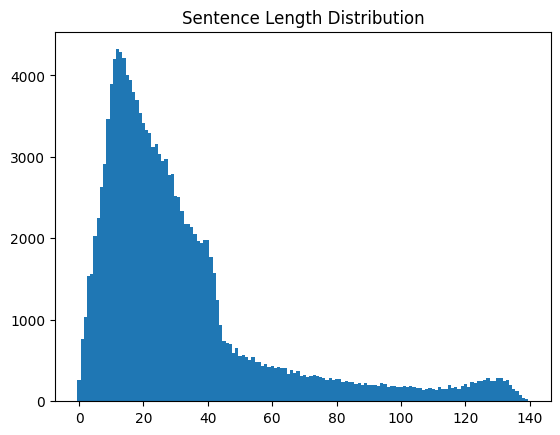

In [23]:
#  문장의 최단 길이, 최장 길이, 평균 길이를 구한 후 문장 길이 분포를 막대그래프로 표현해 주는 소스
min_len = 999
max_len = 0
sum_len = 0

cleaned_corpus = list(set(train_data['document']))
print("Data size:", len(cleaned_corpus))

for sen in train_data['document']: # train_data['document'] 앞서 다운로드받은 데이터가 담긴 변수
    length = len(sen)
    
    # 문장 최소 길이 찾기
    if min_len > length:
        min_len = length
    
    # 문장 최대 길이 찾기
    if max_len < length:
        max_len = length
    
    # 전체 문장을 합쳐서 나온 길이
    sum_len += length
    
print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(train_data))

# 전체 길이를 0 벡터로 만듦. 
# 길이에 따른 문장의 수를 저장하기 위해서 0으로 이루어진 list를 만듦.
#분포도 그려보자
sentence_length = np.zeros((max_len), dtype=np.int) 

# 0으로 이루어진 벡터에 문장 count를 더한 뒤 넣는다.
for sen in train_data['document']:
    sentence_length[len(sen)-1] += 1 

plt.bar(range(max_len), sentence_length, width=1.0) # 너비는 1.0씩 늘어나도록 설정
plt.title("Sentence Length Distribution")
plt.show()

/tmp/ipykernel_47814/3973514937.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sentence_length = np.zeros((max_len), dtype=np.int)


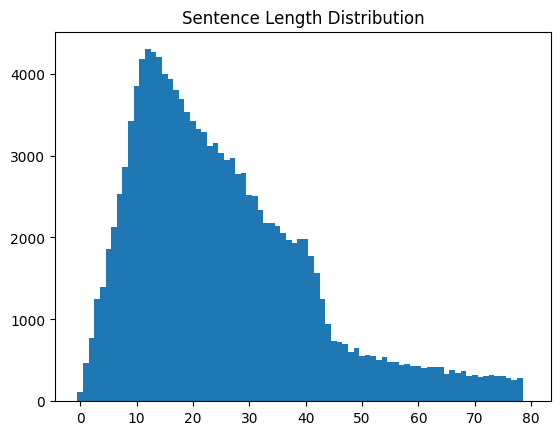

In [24]:
max_len = 80
min_len = 1

# 길이 조건에 맞는 문장만 선택합니다.
filtered_corpus = [s for s in cleaned_corpus if (len(s) < max_len) & (len(s) >= min_len)]

# 분포도를 다시 그려봅니다.
sentence_length = np.zeros((max_len), dtype=np.int)

for sen in filtered_corpus:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [25]:
# Sentencepiece unigram #
temp_file = '/mnt/disk2/modoo-nlp/sp_tokenizer/data/korean-english-park.train.ko.temp'

vocab_size = 8000

with open(temp_file, 'w') as f:
    for row in filtered_corpus:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=naver_korean_spm01  --vocab_size={}'.format(temp_file, vocab_size)    
)
#위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.

print('done')

done


sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/mnt/disk2/modoo-nlp/sp_tokenizer/data/korean-english-park.train.ko.temp --model_prefix=naver_korean_spm01  --vocab_size=8000
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /mnt/disk2/modoo-nlp/sp_tokenizer/data/korean-english-park.train.ko.temp
  input_format: 
  model_prefix: naver_korean_spm01
  model_type: UNIGRAM
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 

In [26]:
!ls -l naver_korean_spm01*

-rw-rw-r-- 1 ubuntu ubuntu 378423 Oct 19 08:27 naver_korean_spm01.model
-rw-rw-r-- 1 ubuntu ubuntu 147913 Oct 19 08:27 naver_korean_spm01.vocab


In [27]:
# Sentencepiece BPE(Byte Pair Encoding) #
temp_file = '/mnt/disk2/modoo-nlp/sp_tokenizer/data/korean-english-park.train.ko.temp'

vocab_size = 8000

with open(temp_file, 'w') as f:
    for row in filtered_corpus:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=naver_korean_spm02 --model_type=bpe --vocab_size={}'.format(temp_file, vocab_size)    
)
#위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.

print('done')

done


sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/mnt/disk2/modoo-nlp/sp_tokenizer/data/korean-english-park.train.ko.temp --model_prefix=naver_korean_spm02 --model_type=bpe --vocab_size=8000
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /mnt/disk2/modoo-nlp/sp_tokenizer/data/korean-english-park.train.ko.temp
  input_format: 
  model_prefix: naver_korean_spm02
  model_type: BPE
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_v

In [28]:
!ls -l naver_korean_spm02*

-rw-rw-r-- 1 ubuntu ubuntu 373736 Oct 19 08:27 naver_korean_spm02.model
-rw-rw-r-- 1 ubuntu ubuntu 118928 Oct 19 08:27 naver_korean_spm02.vocab


#### 2. 학습된 모델로 sp_tokenize() 메소드 구현하기

In [29]:
# tokenize unigram #
def sp_tokenize_unigram(s, corpus):

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./naver_korean_spm01.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({word:idx})
        index_word.update({idx:word})
    # 패딩을 하였다.
    
    # padding='pre' 은 패딩할때 앞단에 0을 넣어주는 방식이다.
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='pre')
    
    return tensor, word_index, index_word

In [30]:
# tokenize bpe #
def sp_tokenize_bpe(s, corpus):

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))
   
    with open("./naver_korean_spm02.vocab", 'r') as f:
        vocab = f.readlines()
    
    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({word:idx})
        index_word.update({idx:word})
    # 패딩을 하였다.
    
    # padding='pre' 은 패딩할때 앞단에 0을 넣어주는 방식이다.
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='pre')
    
    return tensor, word_index, index_word

#### 3. 구현된 토크나이저를 적용하여 네이버 영화리뷰 감정 분석 모델을 재학습하기

In [31]:
# unigram #
s_unigram = spm.SentencePieceProcessor()
s_unigram.Load('naver_korean_spm01.model')

True

In [32]:
def load_data_unigram(train_data, test_data, stpiece_model):
    sentences =[]
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 

    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    #train데이터 토큰화
    sentences = train_data['document'] 
    # unigram
    tensor, word_index, index_word = sp_tokenize_unigram(s_unigram, sentences)
    
    #train문장데이터를 수치화로 표현화한 리스트
    X_train = []
    ## 수치화된 문장(텐서)를 리스트(sentences_index)에 넣어준다. 
    for array in tensor:
        X_train.append(array)
        
    #test데이터 토큰화
    sentences = test_data['document']
    # unigram
    tensor, word_index, index_word = sp_tokenize_unigram(s_unigram, sentences)
    
    # test문장데이터를 수치화로 표현화한 리스트
    X_test = []
    for array in tensor:
        X_test.append(array)
        
    X_train = np.asarray(X_train)
    X_test = np.asarray(X_test)
    
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_index

In [33]:
# bpe #
s_bpe = spm.SentencePieceProcessor()
s_bpe.Load('naver_korean_spm02.model')

True

In [34]:
def load_data_bpe(train_data, test_data, stpiece_model):
    sentences =[]
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 

    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    #train데이터 토큰화
    sentences = train_data['document'] 
    # BPE
    tensor, word_index, index_word = sp_tokenize_bpe(s_bpe, sentences)
    
    #train문장데이터를 수치화로 표현화한 리스트
    X_train = []
    ## 수치화된 문장(텐서)를 리스트(sentences_index)에 넣어준다. 
    for array in tensor:
        X_train.append(array)
        
    #test데이터 토큰화
    sentences = test_data['document']
    # bpe
    tensor, word_index, index_word = sp_tokenize_bpe(s_bpe, sentences)
    
    # test문장데이터를 수치화로 표현화한 리스트
    X_test = []
    for array in tensor:
        X_test.append(array)
        
    X_train = np.asarray(X_train)
    X_test = np.asarray(X_test)
    
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_index

In [35]:
#unigram
X_train, y_train, X_test, y_test, word_to_index = load_data_unigram(train_data, test_data,0)

In [36]:
# bpe
X_train_, y_train_, X_test_, y_test_, word_to_index_ = load_data_bpe(train_data, test_data,1)

In [37]:
print(X_train.shape)
print(X_train_.shape)

(143620, 133)
(143620, 111)


In [38]:
# 데이터셋 나누기

# validation set 10000건 분리
X_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_X_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(X_train.shape)
print(y_train.shape)
print(partial_X_train.shape)
print(partial_y_train.shape)

(143620, 133)
(143620,)
(133620, 133)
(133620,)


#### 4. KoNLPy 형태소 분석기를 사용한 모델과 성능 비교하기

In [39]:
# 모델 설계 및 LSTM 모델 사용

vocab_size = 8000    # 어휘 사전의 크기입니다(8,000개의 단어)
word_vector_dim = 150  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)


#LSTM
model = keras.Sequential()
model.add(Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(LSTM(word_vector_dim))   # 가장 널리 쓰이는 RNN인 LSTM 레이어
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid')) 
model.summary()

2022-10-19 08:28:48.102026: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-19 08:28:48.288459: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-19 08:28:48.288729: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-19 08:28:48.291085: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 150)         1200000   
                                                                 
 lstm (LSTM)                 (None, 150)               180600    
                                                                 
 dense (Dense)               (None, 10)                1510      
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1,382,121
Trainable params: 1,382,121
Non-trainable params: 0
_________________________________________________________________


In [41]:
# Sentencepiece unigram
# 모델 학습
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_model = model.fit(partial_X_train, partial_y_train,
                          epochs=epochs,
                          batch_size=512,
                          validation_data=(X_val, y_val),
                          verbose=2)

#모델 테스트셋으로 평가
results = model.evaluate(X_test,  y_test, verbose=2)
print(results)

Epoch 1/10
261/261 - 7s - loss: 0.2824 - accuracy: 0.8785 - val_loss: 0.3124 - val_accuracy: 0.8631 - 7s/epoch - 25ms/step
Epoch 2/10
261/261 - 4s - loss: 0.2644 - accuracy: 0.8863 - val_loss: 0.3140 - val_accuracy: 0.8647 - 4s/epoch - 16ms/step
Epoch 3/10
261/261 - 4s - loss: 0.2480 - accuracy: 0.8943 - val_loss: 0.3190 - val_accuracy: 0.8650 - 4s/epoch - 16ms/step
Epoch 4/10
261/261 - 4s - loss: 0.2304 - accuracy: 0.9027 - val_loss: 0.3289 - val_accuracy: 0.8623 - 4s/epoch - 16ms/step
Epoch 5/10
261/261 - 4s - loss: 0.2113 - accuracy: 0.9126 - val_loss: 0.3459 - val_accuracy: 0.8579 - 4s/epoch - 16ms/step
Epoch 6/10
261/261 - 4s - loss: 0.1900 - accuracy: 0.9224 - val_loss: 0.3801 - val_accuracy: 0.8565 - 4s/epoch - 16ms/step
Epoch 7/10
261/261 - 4s - loss: 0.1663 - accuracy: 0.9337 - val_loss: 0.4143 - val_accuracy: 0.8524 - 4s/epoch - 16ms/step
Epoch 8/10
261/261 - 4s - loss: 0.1414 - accuracy: 0.9454 - val_loss: 0.4602 - val_accuracy: 0.8486 - 4s/epoch - 16ms/step
Epoch 9/10
261/2

In [42]:
# Sentencepiece BPE

# validation set 10000건 분리
X_val_ = X_train_[:10000]   
y_val_ = y_train_[:10000]

# validation set을 제외한 나머지 15000건
partial_X_train_ = X_train_[10000:]  
partial_y_train_ = y_train_[10000:]

print(X_train_.shape)
print(y_train_.shape)
print(partial_X_train_.shape)
print(partial_y_train_.shape)

#LSTM
model_ = keras.Sequential()
model_.add(Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_.add(LSTM(word_vector_dim))   # 가장 널리 쓰이는 RNN인 LSTM 레이어
model_.add(Dense(10, activation='relu'))
model_.add(Dense(1, activation='sigmoid')) 
model_.summary()

model_.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_model_ = model_.fit(partial_X_train_, partial_y_train_,
                            epochs=epochs,
                            batch_size=512,
                            validation_data=(X_val_, y_val_),
                            verbose=2)

results = model_.evaluate(X_test_,  y_test_, verbose=2)
print(results)

(143620, 111)
(143620,)
(133620, 111)
(133620,)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 150)         1200000   
                                                                 
 lstm_1 (LSTM)               (None, 150)               180600    
                                                                 
 dense_2 (Dense)             (None, 10)                1510      
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1,382,121
Trainable params: 1,382,121
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
261/261 - 6s - loss: 0.4514 - accuracy: 0.7893 - val_loss: 0.3489 - val_accuracy: 0.8491 - 6s/epoch - 23ms/step
Epoch

#### KoNLPy에 있는 Mecab, kkma, Okt 등과 비교해 보자.

In [43]:
# 기존에 불러왔던 데이터를 동일하게 사용
train_data.head(3)

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0


In [44]:
tokenizer = Mecab()

In [45]:
# stopwords 추가
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를',
             '으로','자','에','와','한','하다','이','있','하','것','들',
             '그','되','수','이','보','않','없','나','사람','주','아니',
             '등','같','우리','때','년','가','한','지','대하','오','말',
             '일','그렇','위하','때문','그것','두','말하','알','그러나',
             '받','못하','일','그런','또','문제','더','사회','많','그리고',
             '좋','크','따르','중','나오','가지','씨','시키','만들','지금',
             '생각하','그러','속','하나','집','살','모르','적','월','데',
             '자신','안','어떤','내','경우','명','생각','시간','그녀',
             '다시','이런','앞','보이','번','나','다른','어떻','여자','개',
             '전','들','사실','이렇','점','싶','말','정도','좀','원','잘','통하',
             '소리','놓']

stopwords = set(stopwords)

In [46]:
def load_data_macab(train_data, test_data, num_words=10000):
    # 학습데이터의 중복 제거   
    train_data.drop_duplicates(subset=['document'], inplace=True)
    # NaN 결측치 제거
    train_data = train_data.dropna(how = 'any') 
   # 테스트 데이터의 중복 제거 
    test_data.drop_duplicates(subset=['document'], inplace=True)
   # NaN 결측치 제거
    test_data = test_data.dropna(how = 'any') 

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
    
    X_train = list(map(wordlist_to_indexlist, X_train))
    #print(X_train[0])
    X_test = list(map(wordlist_to_indexlist, X_test))
    
    ## X_train, y_train, X_test, y_test, word_to_index 리턴    
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

In [47]:
X_train__, y_train__, X_test__, y_test__, word_to_index__ = load_data_macab(train_data, test_data)

In [48]:
# 문장 최대 길이 maxlen 찾기

total_data_text = list(X_train__) + list(X_test__)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  11.404085225171738
문장길이 최대 :  70
문장길이 표준편차 :  9.246934819654808
pad_sequences maxlen :  29
전체 문장의 0.9326281580550911%가 maxlen 설정값 이내에 포함됩니다. 


In [49]:
# Pading 및 maxlen 적용

#RNN은 입력데이터가 순차적으로 처리되기 때문에 뒤부분 입력이 패딩값(padding)으로 채워지면 비효율적이다.
# padding='pre' 은 패딩할때 앞단에 0을 넣어주는 방식이다.

X_train__ = keras.preprocessing.sequence.pad_sequences(X_train__,
                                                     value=word_to_index__["<PAD>"],
                                                     padding='pre',# 혹은'post'
                                                     maxlen=maxlen)

X_test__ = keras.preprocessing.sequence.pad_sequences(X_test__,
                                                    value=word_to_index__["<PAD>"],
                                                    padding='pre', # 혹은 'post'
                                                    maxlen=maxlen)
print(X_train__.shape)

(143620, 29)


In [50]:
# validation set 10000건 분리
X_val__ = X_train__[:10000]   
y_val__ = y_train__[:10000]

# validation set을 제외한 나머지 15000건
partial_X_train__ = X_train__[10000:]  
partial_y_train__ = y_train__[10000:]

print(X_train__.shape)
print(y_train__.shape)
print(partial_X_train__.shape)
print(partial_y_train__.shape)

(143620, 29)
(143620,)
(133620, 29)
(133620,)


In [51]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 150  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# model 설계
model__ = keras.Sequential()
model__.add(Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model__.add(LSTM(word_vector_dim))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 변경가능
model__.add(Dense(32, activation='relu'))
model__.add(Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model__.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 150)         1500000   
                                                                 
 lstm_2 (LSTM)               (None, 150)               180600    
                                                                 
 dense_4 (Dense)             (None, 32)                4832      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,685,465
Trainable params: 1,685,465
Non-trainable params: 0
_________________________________________________________________


In [52]:
model__.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_model__ = model__.fit(partial_X_train__, partial_y_train__,
                              epochs=epochs,
                              batch_size=512,
                              validation_data=(X_val__, y_val__),
                              verbose=2)

results = model__.evaluate(X_test__,  y_test__, verbose=2)
print(results)

Epoch 1/10
261/261 - 4s - loss: 0.4242 - accuracy: 0.8002 - val_loss: 0.3696 - val_accuracy: 0.8316 - 4s/epoch - 15ms/step
Epoch 2/10
261/261 - 2s - loss: 0.3431 - accuracy: 0.8486 - val_loss: 0.3577 - val_accuracy: 0.8411 - 2s/epoch - 6ms/step
Epoch 3/10
261/261 - 2s - loss: 0.3136 - accuracy: 0.8611 - val_loss: 0.3563 - val_accuracy: 0.8413 - 2s/epoch - 6ms/step
Epoch 4/10
261/261 - 2s - loss: 0.2841 - accuracy: 0.8753 - val_loss: 0.3737 - val_accuracy: 0.8361 - 2s/epoch - 6ms/step
Epoch 5/10
261/261 - 2s - loss: 0.2599 - accuracy: 0.8861 - val_loss: 0.3986 - val_accuracy: 0.8347 - 2s/epoch - 6ms/step
Epoch 6/10
261/261 - 2s - loss: 0.2376 - accuracy: 0.8965 - val_loss: 0.4272 - val_accuracy: 0.8289 - 2s/epoch - 6ms/step
Epoch 7/10
261/261 - 2s - loss: 0.2166 - accuracy: 0.9071 - val_loss: 0.4769 - val_accuracy: 0.8283 - 2s/epoch - 6ms/step
Epoch 8/10
261/261 - 2s - loss: 0.1973 - accuracy: 0.9154 - val_loss: 0.4985 - val_accuracy: 0.8274 - 2s/epoch - 6ms/step
Epoch 9/10
261/261 - 2s

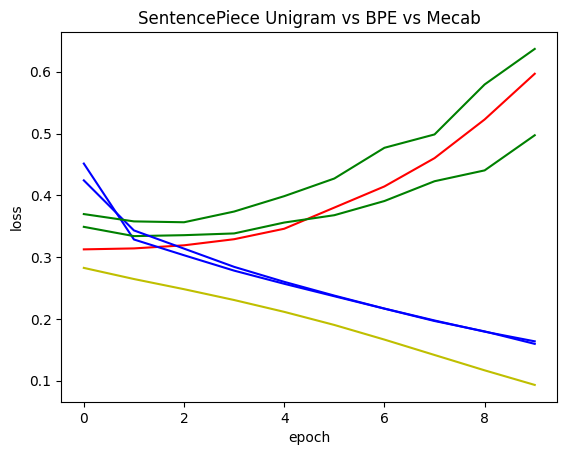

In [53]:
#모델 학습 시각화 
fig, loss_ax = plt.subplots()

loss_ax.plot(history_model.history['loss'], 'y', label='train loss')
loss_ax.plot(history_model.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

loss_ax.plot(history_model_.history['loss'], 'b', label='train loss')
loss_ax.plot(history_model_.history['val_loss'], 'g', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

loss_ax.plot(history_model__.history['loss'], 'b', label='train loss')
loss_ax.plot(history_model__.history['val_loss'], 'g', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

plt.title('SentencePiece Unigram vs BPE vs Mecab')
plt.show()

#### SentencePiece 모델의 model_type, vocab_size 등을 변경해 가면서 성능 개선 여부도 확인해 보자.

In [54]:
model__.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_model__ = model__.fit(partial_X_train__, partial_y_train__,
                              epochs=epochs,
                              batch_size=512,
                              validation_data=(X_val__, y_val__),
                              verbose=2)

results = model__.evaluate(X_test__,  y_test__, verbose=2)
print(results)

Epoch 1/10
261/261 - 4s - loss: 0.1479 - accuracy: 0.9373 - val_loss: 0.7000 - val_accuracy: 0.8193 - 4s/epoch - 15ms/step
Epoch 2/10
261/261 - 2s - loss: 0.1283 - accuracy: 0.9441 - val_loss: 0.7956 - val_accuracy: 0.8174 - 2s/epoch - 6ms/step
Epoch 3/10
261/261 - 2s - loss: 0.1184 - accuracy: 0.9484 - val_loss: 0.8504 - val_accuracy: 0.8186 - 2s/epoch - 6ms/step
Epoch 4/10
261/261 - 2s - loss: 0.1090 - accuracy: 0.9529 - val_loss: 0.9051 - val_accuracy: 0.8137 - 2s/epoch - 6ms/step
Epoch 5/10
261/261 - 2s - loss: 0.1009 - accuracy: 0.9561 - val_loss: 0.9913 - val_accuracy: 0.8166 - 2s/epoch - 6ms/step
Epoch 6/10
261/261 - 2s - loss: 0.0933 - accuracy: 0.9591 - val_loss: 1.0603 - val_accuracy: 0.8179 - 2s/epoch - 6ms/step
Epoch 7/10
261/261 - 2s - loss: 0.0867 - accuracy: 0.9615 - val_loss: 1.1699 - val_accuracy: 0.8181 - 2s/epoch - 6ms/step
Epoch 8/10
261/261 - 2s - loss: 0.0809 - accuracy: 0.9641 - val_loss: 1.1681 - val_accuracy: 0.8130 - 2s/epoch - 6ms/step
Epoch 9/10
261/261 - 2s